In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


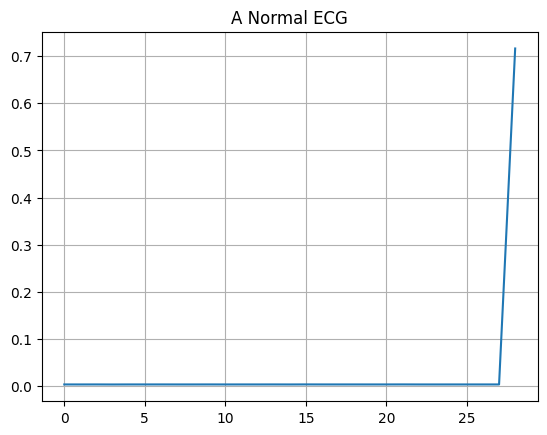

Epoch 1/10
1850/1850 [==============================] - 8s 3ms/step - loss: 0.0223 - val_loss: 9.4839e-04
Epoch 2/10
1850/1850 [==============================] - 13s 7ms/step - loss: 8.1599e-04 - val_loss: 8.2602e-04
Epoch 3/10
1850/1850 [==============================] - 6s 3ms/step - loss: 7.9609e-04 - val_loss: 8.0459e-04
Epoch 4/10
1850/1850 [==============================] - 5s 3ms/step - loss: 7.9331e-04 - val_loss: 8.0645e-04
Epoch 5/10
1850/1850 [==============================] - 7s 4ms/step - loss: 7.9484e-04 - val_loss: 7.9696e-04
Epoch 6/10
1850/1850 [==============================] - 10s 6ms/step - loss: 7.9514e-04 - val_loss: 8.6001e-04
Epoch 7/10
1850/1850 [==============================] - 11s 6ms/step - loss: 7.9471e-04 - val_loss: 8.2684e-04
Epoch 8/10
1850/1850 [==============================] - 8s 4ms/step - loss: 7.9366e-04 - val_loss: 7.9536e-04
Epoch 9/10
1850/1850 [==============================] - 5s 2ms/step - loss: 7.9235e-04 - val_loss: 8.0698e-04
Epoch 10/10

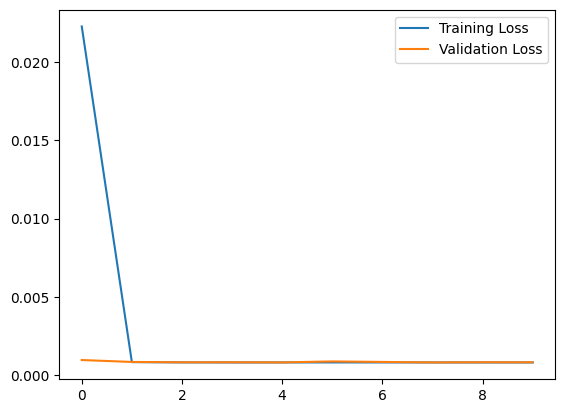

7110/7110 [==============================] - 11s 2ms/step


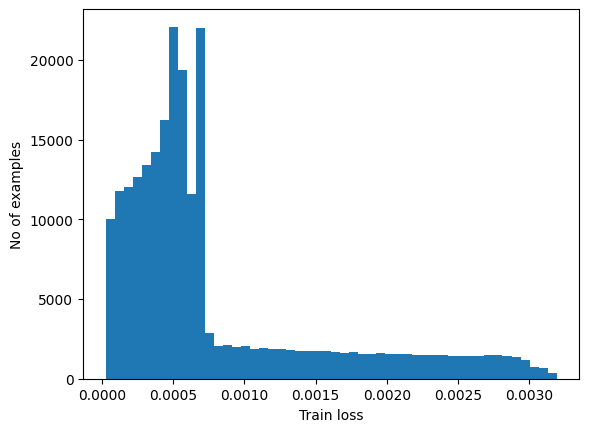

Threshold:  0.0015257727
Accuracy = 0.5007825826987672
Precision = 0.5006843257811842
Recall = 0.8357408969492478


In [ ]:
import pandas as pd
import tensorflow as tf
from keras import layers, losses
from keras.models import Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score


dataset=pd.read_csv('/content/drive/MyDrive/8899/creditcard_2023.csv',header=0,index_col=0)
raw_data=dataset.values

#get classes 1:fraudulent 0:not fraudulent
labels = raw_data[:, -1]


data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=14
)

min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)




train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[~train_labels]
normal_test_data = test_data[~test_labels]

anomalous_train_data = train_data[train_labels]
anomalous_test_data = test_data[test_labels]



plt.grid()
plt.plot( normal_train_data[0])
plt.title("A Normal Record")
plt.show()


class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(29, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(29, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

autoencoder.compile(optimizer='adam', loss='mae')


history = autoencoder.fit(normal_train_data, normal_train_data,
          epochs=10,
          batch_size=123,
          validation_data=(test_data, test_data),
          shuffle=True)

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)




def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Classification Report:
              precision    recall  f1-score   support

       False       0.50      0.17      0.25     56822
        True       0.50      0.84      0.63     56904

    accuracy                           0.50    113726
   macro avg       0.50      0.50      0.44    113726
weighted avg       0.50      0.50      0.44    113726



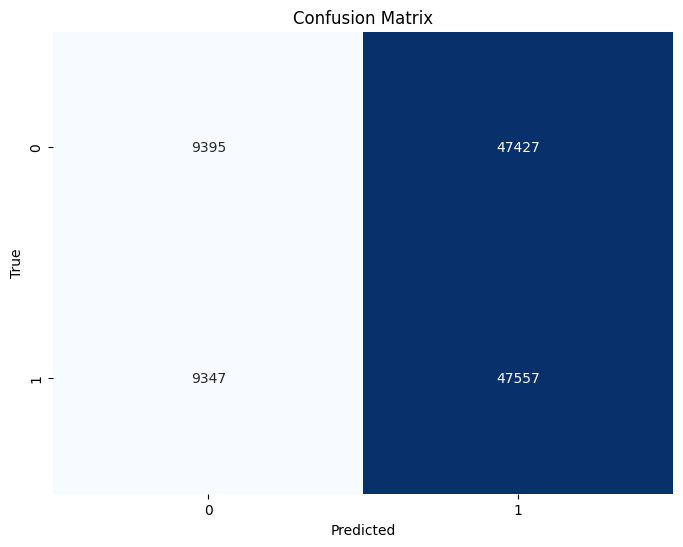

In [ ]:
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
    print("Accuracy = {}".format(accuracy_score(labels, predictions)))
    print("Precision = {}".format(precision_score(labels, predictions)))
    print("Recall = {}".format(recall_score(labels, predictions)))

preds = predict(autoencoder, test_data, threshold)

# Convert predictions and labels to numpy arrays if they are tensors
preds_np = preds.numpy() if isinstance(preds, tf.Tensor) else preds
test_labels_np = test_labels.numpy() if isinstance(test_labels, tf.Tensor) else test_labels

# Print report
print("Report:")
print(classification_report(test_labels_np, preds_np))

# Visualize confusion matrix
cm = confusion_matrix(test_labels_np, preds_np)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
